In [1]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split

In [2]:
def read_data(dataset):
    OUT_FILE_PATH = "/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/%s/out.csv" % dataset
    DATA_FILE_PATH = "/home/sarthak/projects/model_training/new_data/%s.csv" % dataset
    print(OUT_FILE_PATH)
    print(DATA_FILE_PATH)

    out_file = pd.read_csv(OUT_FILE_PATH)
    lim = 0.00
    timesteps = []
    time = []
    for i in range(len(out_file)):
        if(out_file["eff_strain"][i] >= lim):
            timesteps.append(i+1)
            time.append(out_file["time"][i])
            lim = lim + 0.01

    print("Reading %s \n" % dataset)
    # Reading data
    df = pd.read_csv(DATA_FILE_PATH)
    df_dropped = df.drop(columns=['strain_yy', 'phases', 'pressure', 'sdv22', 'sdv23',
                                  'total_strain_xy', 'elem_id', 'blk_id', 'total_stress_xx', 'total_stress_yy',
                                  'total_strain_xx', 'total_strain_yy' ])
    df_norm = (df_dropped-df_dropped.min())/(df_dropped.max()-df_dropped.min())
    df_norm.tail()
    scale_steps = int(np.ceil(len(out_file)/(len(df_dropped)/160000)))
    steps = np.ceil((np.array(timesteps)/scale_steps))
    df_steps = df_dropped[df_dropped["time"].isin(steps)] 
    df_steps_norm = (df_steps-df_steps.min())/(df_steps.max()-df_steps.min())
    df_steps_norm = df_steps_norm.drop(columns=['time'])
    df_group = df_steps_norm.groupby(["elem_x", "elem_y"])
    return df_group

In [3]:
def series_to_supervised(sequences, n_steps_in, n_steps_out, dropnan=True):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix: out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def structure_data(df_group):
    x_raw_list = []
    y_raw_list = []
    for name, group in df_group:
        strain_vals = group['eff_strain'].values
        stress_vals = group['vonmises'].values
        tri_vals = group['triaxiality'].values
        all_vals = np.stack((strain_vals, stress_vals, tri_vals), axis = 1 )
        x, y = series_to_supervised(all_vals, 2, 13)
        x_raw_list.append(x)
        y_raw_list.append(y)
    x_vals = np.concatenate(x_raw_list)
    y_vals = np.concatenate(y_raw_list)
    return x_vals, y_vals, x_raw_list, y_raw_list

In [4]:
base_path = '/home/sarthak/projects/model_training/trained_models/window_lstm'
model = tf.keras.models.load_model(base_path+'/the_model_5_datasets')

# Strain partitioning plot

The first part of this functions is similar to the `read_data` function. It loads the data for a new microsructure and structures it in the format used by the model.

Strain parititioning is commonly observed in dual phase microstructures. Strain partitioning plots shows the comparison of the LSTM predicted and FE predicted average effective strains in the soft and hard phases as a function of applied strain. The following few code snippets extract the data needed for these plots.

In our exodus file, the grain id are called blk_id. In the snippet below we store the grain ids for every elements in the other in which they appear in the microstructure.
Effective strain values for each of the phases are also calculated in the snippet below. Grain id greater than 1297 (for this case, can be obtained from Paraview) belong to the martensite phase. For every timestep, the strain values for both the phases are caculated and stored from the LSTM predictions 

- `one_step`: a vector with values for all the 16,000 elements at a particular timestep.
- `one_step_scaled`: vector with effective strain values for every element at a single timestep on the standard scale.
- `martensite_step`: summation of strain values for all the martensite (hard) phase elements at a single timestep
- `ferrite_step`:  summation of strain values for all the ferrite (soft) phase elements at a single timestep
- `martensite_count`: number of martensite (hard) elements
- `ferrite_count`: numbero of ferrite (soft) elements
- `martensite_strain_steps`: list of average strain values of martensite (hard) elements at all timesteps
- `ferrite_strain_steps`: list of average strain values of ferrible (soft) elements at all timesteps

- `blk_id_ordered`: list of grain id of all elements, in the order they appear on the microstructure

The actual plotting takes place at the end of function

- `martensite`: FE values for the martensite (hard) phase 
- `ferrite`: FE values for the ferrite (soft) phase
- `martensite_strain`: FE effective strain values for the martensite (hard) phase at all timesteps
- `ferrite_strain`: FE effective strain values for the ferrite (soft) phase at all timesteps


In [7]:
def make_partition(dataset, start, stop, model):
    OUT_FILE_PATH = "/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/%s/out.csv" % dataset
    DATA_FILE_PATH = "/home/sarthak/projects/model_training/new_data/%s.csv" % dataset
    PLOTS_PATH = "/home/sarthak/projects/model_training/trained_models/window_lstm/predictions/good"
    print(OUT_FILE_PATH)
    print(DATA_FILE_PATH)

    out_file = pd.read_csv(OUT_FILE_PATH)
    lim = 0.00
    timesteps = []
    time = []
    for i in range(len(out_file)):
        if(out_file["eff_strain"][i] >= lim):
            timesteps.append(i+1)
            time.append(out_file["time"][i])
            lim = lim + 0.01

    print("Reading %s \n" % dataset)
    # Reading data
    df = pd.read_csv(DATA_FILE_PATH)
    df_dropped = df.drop(columns=['phases', 'pressure', 'sdv22', 'sdv23',
                                  'total_strain_xy', 'elem_id', 'blk_id', 'total_stress_xx', 'total_stress_yy',
                                  'total_strain_xx', 'total_strain_yy' ])
    df_norm = (df_dropped-df_dropped.min())/(df_dropped.max()-df_dropped.min())
    df_norm.tail()
    scale_steps = int(np.ceil(len(out_file)/(len(df_dropped)/160000)))
    steps = np.ceil((np.array(timesteps)/scale_steps))
    df_steps = df_dropped[df_dropped["time"].isin(steps)] 
    df_steps_norm = (df_steps-df_steps.min())/(df_steps.max()-df_steps.min())
    df_steps_norm = df_steps_norm.drop(columns=['time'])
    df_group = df_steps_norm.groupby(["elem_x", "elem_y"])
    
    x_vals, y_vals, x_raw_list, y_raw_list = structure_data(df_group)
    input_step = np.array(x_raw_list)[:,start,:,:]
    next_step = model.predict(input_step)
    input_step = np.concatenate(((np.delete(input_step, 0, 1)), next_step), axis = 1)
    true_val = np.array(y_raw_list)
    ans = true_val[:,0,:,:]
    blk_group = df.groupby(["elem_x", "elem_y"])
    blk_id_ordered = []
    for name, group in blk_group:
        blk_id_ordered.append(group['blk_id'].values[0])
    
    martensite_strain_steps = [0]
    ferrite_strain_steps = [0]
    
    for j in range(0,13):
        var_name = 'eff_strain'
        one_step_scaled = (next_step[:,j,0]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        martensite_step = 0
        ferrite_step = 0
        martensite_count = 0
        ferrite_count = 0
        for i in range(len(one_step_scaled)):
            #print(i)
            if blk_id_ordered[i] >= 1297:
                martensite_step += one_step_scaled[i]
                martensite_count += 1
            elif blk_id_ordered[i] < 1297:
                ferrite_step += one_step_scaled[i]
                ferrite_count += 1
        martensite_strain_steps.append(martensite_step/martensite_count)
        ferrite_strain_steps.append(ferrite_step/ferrite_count)
    
    variables = ["eff_strain", "vonmises", "triaxiality"]
    print(martensite_strain_steps)
    strain_yy_steps = df_steps.strain_yy.unique()
    strain_yy_steps[0] = 0
    martensite = df.loc[df['blk_id']>=1297]
    ferrite = df.loc[df['blk_id']<1297]
    martensite_strain = martensite.groupby('time').mean()['eff_strain']
    strain_yy = df.groupby('time').mean()['strain_yy']
    ferrite_strain = ferrite.groupby('time').mean()['eff_strain']

    print(len(strain_yy_steps), len(ferrite_strain_steps))
    plt.figure()
    plt.rcParams.update({'font.size': 15})
    plt.plot(strain_yy, ferrite_strain, 'b', label='Soft (FE)')
    plt.scatter(strain_yy_steps[2:16], ferrite_strain_steps, marker='o', c='blue', label="Soft (LSTM)")
    plt.plot(strain_yy, martensite_strain, 'r', label="Hard (FE)")
    plt.scatter(strain_yy_steps[2:16], martensite_strain_steps, marker='^', c='red', label="Hard (LSTM)")
    plt.xlabel(r'$\bar{\epsilon}_{app}$')
    plt.ylabel(r'$\bar{\epsilon}$')
    plt.legend()
    plt.savefig(PLOTS_PATH+'/strain_paritioning.png', dpi=700, bbox_inches="tight")

/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/test24/out.csv
/home/sarthak/projects/model_training/new_data/test24.csv
Reading test24 

[0, 0.008031036832635785, 0.010450619408203344, 0.013668112849121537, 0.01696018127181049, 0.020601042905033777, 0.024467537696929127, 0.028627347170166448, 0.032937617039692745, 0.037420683420420896, 0.042042631765200005, 0.04681990477461067, 0.0517486423973726, 0.05681845823272015]
16 14


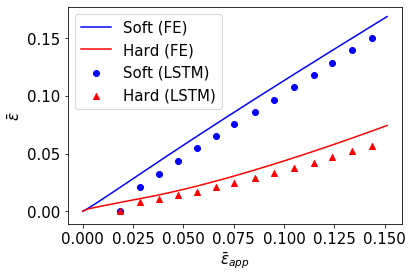

In [8]:
make_partition('test24', 0, 12, model)

# Cross Correlation Plots

The first part of this functions is similar to the `read_data` function. It loads the data for a new microsructure and structures it in the format used by the model.

The function plots of LSTM predicted values vs FE values for all the 3 variables and saves them in the location defined by `PLOTS_PATH`

In [7]:
def make_r2(dataset, start, stop, model):
    OUT_FILE_PATH = "/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/%s/out.csv" % dataset
    DATA_FILE_PATH = "/home/sarthak/projects/model_training/new_data/%s.csv" % dataset
    PLOTS_PATH = "/home/sarthak/projects/model_training/trained_models/window_lstm/predictions/good"
    print(OUT_FILE_PATH)
    print(DATA_FILE_PATH)

    out_file = pd.read_csv(OUT_FILE_PATH)
    lim = 0.00
    timesteps = []
    time = []
    for i in range(len(out_file)):
        if(out_file["eff_strain"][i] >= lim):
            timesteps.append(i+1)
            time.append(out_file["time"][i])
            lim = lim + 0.01

    print("Reading %s \n" % dataset)
    # Reading data
    df = pd.read_csv(DATA_FILE_PATH)
    df_dropped = df.drop(columns=['strain_yy', 'phases', 'pressure', 'sdv22', 'sdv23',
                                  'total_strain_xy', 'elem_id', 'blk_id', 'total_stress_xx', 'total_stress_yy',
                                  'total_strain_xx', 'total_strain_yy' ])
    df_norm = (df_dropped-df_dropped.min())/(df_dropped.max()-df_dropped.min())
    df_norm.tail()
    scale_steps = int(np.ceil(len(out_file)/(len(df_dropped)/160000)))
    steps = np.ceil((np.array(timesteps)/scale_steps))
    df_steps = df_dropped[df_dropped["time"].isin(steps)] 
    df_steps_norm = (df_steps-df_steps.min())/(df_steps.max()-df_steps.min())
    df_steps_norm = df_steps_norm.drop(columns=['time'])
    df_group = df_steps_norm.groupby(["elem_x", "elem_y"])
    
    x_vals, y_vals, x_raw_list, y_raw_list = structure_data(df_group)
    input_step = np.array(x_raw_list)[:,start,:,:]
    next_step = model.predict(input_step)
    input_step = np.concatenate(((np.delete(input_step, 0, 1)), next_step), axis = 1)
    true_val = np.array(y_raw_list)
    ans = true_val[:,0,:,:]
    variables = ["eff_strain", "vonmises", "triaxiality"]
    for j in range(0,3):
        var_name = variables[j]
        true_scaled = (ans[:,stop,j]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        pred_scaled = (next_step[:,stop,j]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        print(r2_score(true_scaled, pred_scaled))
        print(np.sum(abs(true_scaled - pred_scaled))/160000)
        plt.rcParams.update({'font.size': 14})
        plt.figure()

        a = plt.axes(aspect='equal')
        a.text(min(pred_scaled), 0.9*max(pred_scaled), "$R^2$ = %0.2f" %(r2_score(true_scaled, pred_scaled)), fontsize=15)
        plt.scatter(true_scaled.reshape(1, 160000), pred_scaled.reshape(1, 160000))
        xp = [min(pred_scaled),max(pred_scaled)]
        yp = xp
        plt.plot(xp,yp, 'r')
        plt.xlabel('FE Values')
        plt.ylabel('LSTM Predictions')
        plt.savefig(PLOTS_PATH+"/"+var_name+".eps", format='eps') 
        print(var_name+" done")

# Box Plots

To depict the accuracy of our models across all timesteps, we have plotted box plots of mean absolute error at all timesteps for all all the microstructures. The following functions prepares the data for the box plots. It calculates the mean absolute error in the predicted timesteps for each datastructure and stores them in 3 csv files. Each csv files corresponds to a variable and has 25 columns (microstructures) and 13 rows (MAE values).

In [14]:
def make_box(dataset, start, stop, model):
    OUT_FILE_PATH = "/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/%s/out.csv" % dataset
    DATA_FILE_PATH = "/home/sarthak/projects/model_training/new_data/%s.csv" % dataset
    PLOTS_PATH = "/home/sarthak/projects/model_training/trained_models/window_lstm/predictions/good"
    print(OUT_FILE_PATH)
    print(DATA_FILE_PATH)

    out_file = pd.read_csv(OUT_FILE_PATH)
    lim = 0.00
    timesteps = []
    time = []
    for i in range(len(out_file)):
        if(out_file["eff_strain"][i] >= lim):
            timesteps.append(i+1)
            time.append(out_file["time"][i])
            lim = lim + 0.01

    print("Reading %s \n" % dataset)
    # Reading data
    df = pd.read_csv(DATA_FILE_PATH)
    df_dropped = df.drop(columns=['strain_yy', 'phases', 'pressure', 'sdv22', 'sdv23',
                                  'total_strain_xy', 'elem_id', 'blk_id', 'total_stress_xx', 'total_stress_yy',
                                  'total_strain_xx', 'total_strain_yy' ])
    df_norm = (df_dropped-df_dropped.min())/(df_dropped.max()-df_dropped.min())
    df_norm.tail()
    scale_steps = int(np.ceil(len(out_file)/(len(df_dropped)/160000)))
    steps = np.ceil((np.array(timesteps)/scale_steps))
    df_steps = df_dropped[df_dropped["time"].isin(steps)] 
    df_steps_norm = (df_steps-df_steps.min())/(df_steps.max()-df_steps.min())
    df_steps_norm = df_steps_norm.drop(columns=['time'])
    df_group = df_steps_norm.groupby(["elem_x", "elem_y"])
    
    x_vals, y_vals, x_raw_list, y_raw_list = structure_data(df_group)
    input_step = np.array(x_raw_list)[:,start,:,:]
    next_step = model.predict(input_step)
    input_step = np.concatenate(((np.delete(input_step, 0, 1)), next_step), axis = 1)
    true_val = np.array(y_raw_list)
    ans = true_val[:,0,:,:]
    variables = ["eff_strain", "vonmises", "triaxiality"]
    eff_strain_mae = []
    for i in range(0,13):
        var_name = variables[0]
        true_scaled = (ans[:,i,0]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        pred_scaled = (next_step[:,i,0]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()

        eff_strain_mae.append(np.sum(abs(true_scaled - pred_scaled))/160000)   
    
    vonmises_mae = []
    for i in range(0,13):
        var_name = variables[1]
        true_scaled = (ans[:,i,1]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        pred_scaled = (next_step[:,i,1]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()

        vonmises_mae.append(np.sum(abs(true_scaled - pred_scaled))/160000) 
        
    triaxiality_mae = []
    for i in range(0,13):
        var_name = variables[2]
        true_scaled = (ans[:,i,2]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        pred_scaled = (next_step[:,i,2]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()

        triaxiality_mae.append(np.sum(abs(true_scaled - pred_scaled))/160000)
    return np.array(eff_strain_mae), np.array(vonmises_mae), np.array(triaxiality_mae)

In [20]:
dataset_names = ['AR1','AR2', 'AR3', 'AR4', 'AR5',
                'test11', 'test12', 'test13', 'test14', 'test15', 
                'test21', 'test22', 'test23', 'test24', 'test25', 
                'test51', 'test52', 'test53', 'test54', 'test55',
                'test61', 'test62', 'test63', 'test64', 'test65']
dict_strain = {}
dict_stress = {}
dict_tri = {}
for dataset in dataset_names:
    a,b,c = make_box(dataset, 0, 12, model)
    dict_strain[dataset] = a
    dict_stress[dataset] = b
    dict_tri[dataset] = c
    print(dataset + " Done!")
pd.DataFrame.from_dict(dict_stress).to_csv("/home/sarthak/projects/model_training/trained_models/window_lstm/predictions/time_stress.csv", index = False)
pd.DataFrame.from_dict(dict_strain).to_csv("/home/sarthak/projects/model_training/trained_models/window_lstm/predictions/time_strain.csv", index = False)
pd.DataFrame.from_dict(dict_tri).to_csv("/home/sarthak/projects/model_training/trained_models/window_lstm/predictions/time_triaxiality.csv", index = False)

/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/AR1/out.csv
/home/sarthak/projects/model_training/new_data/AR1.csv
Reading AR1 

AR1 Done!
/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/AR2/out.csv
/home/sarthak/projects/model_training/new_data/AR2.csv
Reading AR2 

AR2 Done!
/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/AR3/out.csv
/home/sarthak/projects/model_training/new_data/AR3.csv
Reading AR3 

AR3 Done!
/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/AR4/out.csv
/home/sarthak/projects/model_training/new_data/AR4.csv
Reading AR4 

AR4 Done!
/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/AR5/out.csv
/home/sarthak/projects/model_training/new_data/AR5.csv
Reading AR5 

AR5 Done!
/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/test11/out.csv
/home/sarthak/projects/model_training/new_data/test11.csv
Reading test11 

test11 Done!
/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/test12/out.csv
/home/sarthak/projects/model_traini

# Contour Plots

The following code reads the data and plots the predicted contour plots for the 3 variables at the final timestep.

In [20]:
def make_contours(dataset, start, stop, model):
    OUT_FILE_PATH = "/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/%s/out.csv" % dataset
    DATA_FILE_PATH = "/home/sarthak/projects/model_training/new_data/%s.csv" % dataset
    PLOTS_PATH = "/home/sarthak/projects/model_training/trained_models/window_lstm/predictions/good"
    print(OUT_FILE_PATH)
    print(DATA_FILE_PATH)

    out_file = pd.read_csv(OUT_FILE_PATH)
    lim = 0.00
    timesteps = []
    time = []
    for i in range(len(out_file)):
        if(out_file["eff_strain"][i] >= lim):
            timesteps.append(i+1)
            time.append(out_file["time"][i])
            lim = lim + 0.01

    print("Reading %s \n" % dataset)
    # Reading data
    df = pd.read_csv(DATA_FILE_PATH)
    df_dropped = df.drop(columns=['strain_yy', 'phases', 'pressure', 'sdv22', 'sdv23',
                                  'total_strain_xy', 'elem_id', 'blk_id', 'total_stress_xx', 'total_stress_yy',
                                  'total_strain_xx', 'total_strain_yy' ])
    df_norm = (df_dropped-df_dropped.min())/(df_dropped.max()-df_dropped.min())
    df_norm.tail()
    scale_steps = int(np.ceil(len(out_file)/(len(df_dropped)/160000)))
    steps = np.ceil((np.array(timesteps)/scale_steps))
    df_steps = df_dropped[df_dropped["time"].isin(steps)] 
    df_steps_norm = (df_steps-df_steps.min())/(df_steps.max()-df_steps.min())
    df_steps_norm = df_steps_norm.drop(columns=['time'])
    df_group = df_steps_norm.groupby(["elem_x", "elem_y"])
    
    x_vals, y_vals, x_raw_list, y_raw_list = structure_data(df_group)
    input_step = np.array(x_raw_list)[:,start,:,:]
    next_step = model.predict(input_step)
    input_step = np.concatenate(((np.delete(input_step, 0, 1)), next_step), axis = 1)
    true_val = np.array(y_raw_list)
    ans = true_val[:,0,:,:]
    variables = ["eff_strain", "vonmises", "triaxiality"]
    for j in range(0,3):
        var_name = variables[j]
        true_scaled = (ans[:,stop,j]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        pred_scaled = (next_step[:,stop,j]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        yy_levels = [-1.2, -0.9, -0.6, -0.3, 0.0, 0.3, 0.6, 0.9, 1.2, 1.5]
        # Contour of LSTM Values
        plt.rcParams.update({'font.size': 14})
        xlist = np.arange(0.25, 100.25, 0.25)
        ylist = np.arange(0.25, 100.25, 0.25)
        X,Y = np.meshgrid(xlist, ylist)
        Z = pred_scaled.reshape(400, 400)
        fig,ax=plt.subplots(1,1)
        mycmap1 = plt.get_cmap('rainbow')
        cp = ax.contourf(X, Y, Z, cmap=mycmap1, levels = yy_levels)
        cbar = fig.colorbar(cp) # Add a colorbar to a plot
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('x ($\mu m$)')
        ax.set_ylabel('y ($\mu m$)')
        plt.savefig(PLOTS_PATH+'/contour_lstm_'+var_name+'.eps', format='eps')


In [ ]:
make_contours("test24", 0, 12, model)

/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/test24/out.csv
/home/sarthak/projects/model_training/new_data/test24.csv
Reading test24 



# Stress Strain Curve

The following function reads the data and plots a stress strain curve for the predicted as well as the FE values.

In [20]:
def make_stress_strain(dataset, start, stop, model):
    OUT_FILE_PATH = "/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/%s/out.csv" % dataset
    DATA_FILE_PATH = "/home/sarthak/projects/model_training/new_data/%s.csv" % dataset
    PLOTS_PATH = "/home/sarthak/projects/model_training/trained_models/window_lstm/predictions/good"
    print(OUT_FILE_PATH)
    print(DATA_FILE_PATH)

    out_file = pd.read_csv(OUT_FILE_PATH)
    lim = 0.00
    timesteps = []
    time = []
    for i in range(len(out_file)):
        if(out_file["eff_strain"][i] >= lim):
            timesteps.append(i+1)
            time.append(out_file["time"][i])
            lim = lim + 0.01

    print("Reading %s \n" % dataset)
    # Reading data
    df = pd.read_csv(DATA_FILE_PATH)
    df_dropped = df.drop(columns=['strain_yy', 'phases', 'pressure', 'sdv22', 'sdv23',
                                  'total_strain_xy', 'elem_id', 'blk_id', 'total_stress_xx', 'total_stress_yy',
                                  'total_strain_xx', 'total_strain_yy' ])
    df_norm = (df_dropped-df_dropped.min())/(df_dropped.max()-df_dropped.min())
    df_norm.tail()
    scale_steps = int(np.ceil(len(out_file)/(len(df_dropped)/160000)))
    steps = np.ceil((np.array(timesteps)/scale_steps))
    df_steps = df_dropped[df_dropped["time"].isin(steps)] 
    df_steps_norm = (df_steps-df_steps.min())/(df_steps.max()-df_steps.min())
    df_steps_norm = df_steps_norm.drop(columns=['time'])
    df_group = df_steps_norm.groupby(["elem_x", "elem_y"])
    
    x_vals, y_vals, x_raw_list, y_raw_list = structure_data(df_group)
    #df_group = df_group[["eff_strain", "vonmises", "triaxiality"]]
    #first_step = df_group.nth(start).values.reshape(160000, 1, 3)
    input_step = np.array(x_raw_list)[:,start,:,:]
    #next_step = model.predict(first_step)
    next_step = model.predict(input_step)
    input_step = np.concatenate(((np.delete(input_step, 0, 1)), next_step), axis = 1)
    true_val = np.array(y_raw_list)
    ans = true_val[:,0,:,:]
    variables = ["eff_strain", "vonmises", "triaxiality"]
    eff_strain = []
    vonmises = []
    for i in range(0,2):
        var_name = variables[0]
        pred_scaled = (input_step[:,i,0]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        eff_strain.append(np.sum(pred_scaled)/160000)
        
        var_name = variables[1]
        pred_scaled = (input_step[:,i,1]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        vonmises.append(np.sum(pred_scaled)/160000) 
    
    for i in range(0,13):
        var_name = variables[0]
        true_scaled = (ans[:,i,0]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        pred_scaled = (next_step[:,i,0]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        eff_strain.append(np.sum(pred_scaled)/160000)   
    
  
    for i in range(0,13):
        var_name = variables[1]
        true_scaled = (ans[:,i,1]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()
        pred_scaled = (next_step[:,i,1]*(df_steps[var_name].max() - df_steps[var_name].min())) + df_steps[var_name].min()

        vonmises.append(np.sum(pred_scaled)/160000) 
    df = pd.read_csv(OUT_FILE_PATH)
    plt.figure()
    plt.rcParams.update({'font.size': 15})
    plt.plot(df['eff_strain'], df['vonmises'], label='FE Values')
    plt.xlabel(r'$\bar{\epsilon}$')
    plt.ylabel(r'$\bar{\sigma}$  (MPa)')
    plt.scatter(eff_strain, vonmises, label='LSTM Predictions')
    plt.legend()
    plt.savefig(PLOTS_PATH+'/pred_stress_strain.png', dpi=700, bbox_inches="tight")

/home/sarthak/projects/seacas-exodus/lib/soudip_dataset/test24/out.csv
/home/sarthak/projects/model_training/new_data/test24.csv
Reading test24 



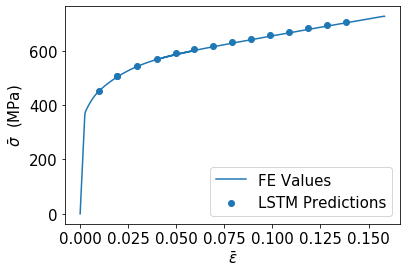

In [21]:
make_stress_strain("test24", 0, 12, model)